In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("punkt")
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [45]:
# Loading the dataset
df = pd.read_csv("../data/raw/blogtext.csv")
print(df.shape)

(681284, 7)


In [50]:
df = df.sample(n=50000, random_state=42)

In [51]:
df.columns

Index(['id', 'gender', 'age', 'topic', 'sign', 'date', 'text'], dtype='object')

In [52]:
df.isnull().sum()

id        0
gender    0
age       0
topic     0
sign      0
date      0
text      0
dtype: int64

In [53]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,50000.0,2.391699e+06,1.249844e+06,5114.0,1234212.0,2591513.0,3523319.0,4336871.0
age,50000.0,2.397172e+01,7.796685e+00,13.0,17.0,24.0,27.0,48.0


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 358401 to 365471
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      50000 non-null  int64 
 1   gender  50000 non-null  object
 2   age     50000 non-null  int64 
 3   topic   50000 non-null  object
 4   sign    50000 non-null  object
 5   date    50000 non-null  object
 6   text    50000 non-null  object
dtypes: int64(2), object(5)
memory usage: 3.1+ MB


In [55]:
# Creating a new dataframe with two columns
df = df[["sign", "text"]]

In [56]:
print(df.shape)

(50000, 2)


In [57]:
pd.set_option("display.max_colwidth", 100)
df.head()

,sign,text
358401,Leo,urlLink UNH Biodiesel Group : 'Widescale Biodiesel Production from Algae'
609144,Sagittarius,"Friday,723/o4,&nbsp;was the first day of our two day garage sale.&nbsp; It di..."
572214,Taurus,As the head line says ‘Planet-X down under’ is coming and its ready to rock and roll. Pla...
158338,Cancer,"An Ancient-Future Message Yes, I admit the title of this blog derives from Rober..."
319033,Pisces,"I know I've been lax in my updates, but I've been swamped. So here goes the update...."


In [58]:
# Checking how many unique signs are there
pd.DataFrame(df.sign.unique()).values

array([['Leo'],
       ['Sagittarius'],
       ['Taurus'],
       ['Cancer'],
       ['Pisces'],
       ['Virgo'],
       ['Aquarius'],
       ['Aries'],
       ['Libra'],
       ['Capricorn'],
       ['Scorpio'],
       ['Gemini']], dtype=object)

In [59]:
# Create a new column 'sign_id' with encoded signs 
df["sign_id"] = df["sign"].factorize()[0]
sign_id_df = df[["sign", "sign_id"]].drop_duplicates()

In [60]:
# Dictionaries for future use
sign_to_id = dict(sign_id_df.values)
id_to_sign = dict(sign_id_df[["sign_id", "sign"]].values)

# New dataframe
df.head()

,sign,text,sign_id
358401,Leo,urlLink UNH Biodiesel Group : 'Widescale Biodiesel Production from Algae',0
609144,Sagittarius,"Friday,723/o4,&nbsp;was the first day of our two day garage sale.&nbsp; It di...",1
572214,Taurus,As the head line says ‘Planet-X down under’ is coming and its ready to rock and roll. Pla...,2
158338,Cancer,"An Ancient-Future Message Yes, I admit the title of this blog derives from Rober...",3
319033,Pisces,"I know I've been lax in my updates, but I've been swamped. So here goes the update....",4


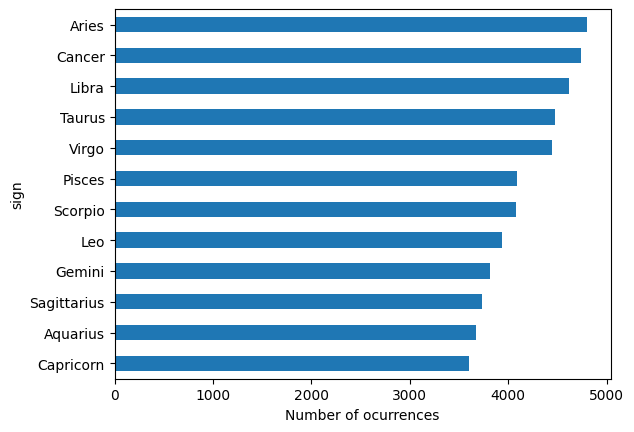

In [61]:
# Visualize the data
fig = plt.figure()
df.groupby("sign").text.count().sort_values().plot.barh(ylim=0)
plt.xlabel("Number of ocurrences", fontsize = 10);

In [15]:
# Pre-processing the "text" column

In [62]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [63]:
# removing punctuation
def remove_punctuation(text):
    text = "".join([c for c in text if c not in string.punctuation])
    return text

df["text"] = df["text"].apply(lambda x: remove_punctuation(x))
df.head(2)

,sign,text,sign_id
358401,Leo,urlLink UNH Biodiesel Group Widescale Biodiesel Production from Algae,0
609144,Sagittarius,Friday723o4nbspwas the first day of our two day garage salenbsp It didnt star...,1


In [64]:
# removing unwanted characters
df["text"] = df["text"].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', " ", x))

In [65]:
# removing whitespaces (begining and trailing spaces)
df["text"] = df["text"].apply(lambda x: x.strip())

In [89]:
# replacing more than 1 spaces with single space
df["text"] = df["text"].str.replace(r"\s\s+", " ")
df.head()

,sign,text,sign_id
358401,Leo,urllink unh biodiesel group widescale biodiesel production algae,0
609144,Sagittarius,friday723o4nbspwas first day two day garage salenbsp didnt start great supposed set 9 friend did...,1
572214,Taurus,head line say planetx coming ready rock roll planetx possibly biggest bikeroller skatemotorbikes...,2
158338,Cancer,ancientfuture message yes admit title blog derives robert webbers book ancientfuture faith webbe...,3
319033,Pisces,know ive lax update ive swamped go update friday night went husky village intern staying party d...,4


In [67]:
# tokenization
def tokenize(text):
    tokens = re.split("\W+", text)
    return tokens

df["text"] = df["text"].apply(lambda x: tokenize(x.lower()))
df.head()

,sign,text,sign_id
358401,Leo,"[urllink, unh, biodiesel, group, widescale, biodiesel, production, from, algae]",0
609144,Sagittarius,"[friday723o4nbspwas, the, first, day, of, our, two, day, garage, salenbsp, it, didnt, start, out...",1
572214,Taurus,"[as, the, head, line, says, planetx, down, under, is, coming, and, its, ready, to, rock, and, ro...",2
158338,Cancer,"[an, ancientfuture, message, yes, i, admit, the, title, of, this, blog, derives, from, robert, w...",3
319033,Pisces,"[i, know, ive, been, lax, in, my, updates, but, ive, been, swamped, so, here, goes, the, update,...",4


In [68]:
# removing stopwords
stopwords = nltk.corpus.stopwords.words("english")
stopwords[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [69]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopwords]
    return text

df["text"] = df["text"].apply(lambda x: remove_stopwords(x))
df.head()

,sign,text,sign_id
358401,Leo,"[urllink, unh, biodiesel, group, widescale, biodiesel, production, algae]",0
609144,Sagittarius,"[friday723o4nbspwas, first, day, two, day, garage, salenbsp, didnt, start, great, supposed, set,...",1
572214,Taurus,"[head, line, says, planetx, coming, ready, rock, roll, planetx, possibly, biggest, bikeroller, s...",2
158338,Cancer,"[ancientfuture, message, yes, admit, title, blog, derives, robert, webbers, book, ancientfuture,...",3
319033,Pisces,"[know, ive, lax, updates, ive, swamped, goes, update, friday, night, went, husky, village, inter...",4


In [70]:
wn = nltk.WordNetLemmatizer()

In [71]:
# lemmatization
def lemmatization(text):
    text = [wn.lemmatize(word) for word in text]
    return " ".join(text)

df["text"] = df["text"].apply(lambda x: lemmatization(x))
df.head()

,sign,text,sign_id
358401,Leo,urllink unh biodiesel group widescale biodiesel production algae,0
609144,Sagittarius,friday723o4nbspwas first day two day garage salenbsp didnt start great supposed set 9 friend did...,1
572214,Taurus,head line say planetx coming ready rock roll planetx possibly biggest bikeroller skatemotorbikes...,2
158338,Cancer,ancientfuture message yes admit title blog derives robert webbers book ancientfuture faith webbe...,3
319033,Pisces,know ive lax update ive swamped go update friday night went husky village intern staying party d...,4


In [26]:
# Further Text processing using TF-IDF

In [102]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=0.05, max_features=800, ngram_range=(1,2), stop_words="english")

In [103]:
# Transforming each text into a vector
features = tfidf.fit_transform(df.text).toarray()
labels = df.sign_id
print(features.shape)

(50000, 184)


In [104]:
tfidf.vocabulary_

{'urllink': 159,
 'day': 22,
 'didnt': 24,
 'start': 136,
 'great': 49,
 'friend': 38,
 'thing': 146,
 'going': 45,
 'able': 0,
 'quite': 118,
 'bit': 9,
 'went': 170,
 'house': 63,
 'like': 80,
 'good': 47,
 'head': 57,
 'say': 128,
 'coming': 18,
 'yes': 181,
 'blog': 10,
 'book': 11,
 'today': 151,
 'time': 150,
 'away': 3,
 'long': 83,
 'little': 81,
 'ive': 70,
 'reason': 122,
 'people': 108,
 'come': 17,
 'life': 79,
 'write': 177,
 'mind': 93,
 'way': 167,
 'idea': 65,
 'person': 109,
 'god': 44,
 'world': 176,
 'live': 82,
 'know': 74,
 'looking': 85,
 'night': 103,
 'left': 77,
 'kid': 72,
 'game': 41,
 'make': 88,
 'guess': 50,
 'end': 29,
 'actually': 1,
 'funny': 40,
 'really': 121,
 'hand': 52,
 'making': 89,
 'room': 125,
 'old': 106,
 'song': 133,
 'mean': 92,
 'point': 113,
 'care': 15,
 'turn': 158,
 'yeah': 179,
 'girl': 43,
 'car': 14,
 'guy': 51,
 'home': 60,
 'place': 111,
 'took': 155,
 'hour': 62,
 'got': 48,
 'minute': 94,
 'called': 12,
 'maybe': 91,
 'decided'

In [106]:
# Finding the two most correlated terms with each of the sign categories
N = 3
for sign, sign_id in sorted(sign_to_id.items()):
    features_chi2 = chi2(features, labels == sign_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(" ")) == 1]
    bigrams = [v for v in feature_names if len(v.split(" ")) == 2]
    print("n--> %s:" %(sign))
    print("  * Most Correlated Unigrams are: %s" %(", ".join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(", ".join(bigrams[-N:])))

n--> Aquarius:
  * Most Correlated Unigrams are: people, book, school
  * Most Correlated Bigrams are: dont know, im going
n--> Aries:
  * Most Correlated Unigrams are: watch, tomorrow, job
  * Most Correlated Bigrams are: im going, dont know
n--> Cancer:
  * Most Correlated Unigrams are: real, im, ok
  * Most Correlated Bigrams are: dont know, im going
n--> Capricorn:
  * Most Correlated Unigrams are: bit, havent, gonna
  * Most Correlated Bigrams are: im going, dont know
n--> Gemini:
  * Most Correlated Unigrams are: job, movie, point
  * Most Correlated Bigrams are: im going, dont know
n--> Leo:
  * Most Correlated Unigrams are: urllink, used, picture
  * Most Correlated Bigrams are: im going, dont know
n--> Libra:
  * Most Correlated Unigrams are: im, ok, urllink
  * Most Correlated Bigrams are: dont know, im going
n--> Pisces:
  * Most Correlated Unigrams are: house, happy, ok
  * Most Correlated Bigrams are: im going, dont know
n--> Sagittarius:
  * Most Correlated Unigrams are: 

In [30]:
# Multi-classification Modeling

In [107]:
X = df["text"] # Collection of blogs
y = df["sign"] # Target or the labels we want to predict (i.e. the 12 different zodiac signs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [108]:
models = [
    RandomForestClassifier(n_estimators=100, random_state=42),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=42),
]
# Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:   
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring="accuracy", cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=["model_name", "fold_idx", "accuracy"])

In [84]:
# Compare Text Classification Model performance

In [109]:
mean_accuracy = cv_df.groupby("model_name").accuracy.mean()
std_accuracy = cv_df.groupby("model_name").accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis=1, ignore_index=True)
acc.columns = ["Mean Accuracy", "Standard deviation"]
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.10046,0.004056
LogisticRegression,0.10092,0.003461
MultinomialNB,0.10264,0.002390
RandomForestClassifier,0.09836,0.003626


In [35]:
# Evaluation of Text Classification Model

In [110]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, labels, df.index, test_size=0.3, random_state=42)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: %.4f" % accuracy_score(y_test, y_pred))

Accuracy: 0.1021


In [111]:
# Classification report
print(metrics.classification_report(y_test, y_pred, labels=[1,2,3,4,5,6,7,8,9,10,11,12], target_names= df["sign"].unique()))

              precision    recall  f1-score   support

         Leo       0.07      0.02      0.03      1126
 Sagittarius       0.11      0.15      0.13      1359
      Taurus       0.10      0.17      0.13      1437
      Cancer       0.10      0.10      0.10      1224
      Pisces       0.10      0.16      0.13      1324
       Virgo       0.12      0.03      0.05      1127
    Aquarius       0.12      0.22      0.15      1471
       Aries       0.09      0.15      0.11      1334
       Libra       0.09      0.02      0.04      1065
   Capricorn       0.08      0.03      0.05      1212
     Scorpio       0.07      0.04      0.05      1128
      Gemini       0.00      0.00      0.00         0

   micro avg       0.10      0.11      0.10     13807
   macro avg       0.09      0.09      0.08     13807
weighted avg       0.10      0.11      0.09     13807



c:\users\rahul\pycharmprojects\naturallanguageprocessingproject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\rahul\pycharmprojects\naturallanguageprocessingproject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\rahul\pycharmprojects\naturallanguageprocessingproject\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

In [38]:
# Now let's plot the confusion matrix to check the miss classified predictions:

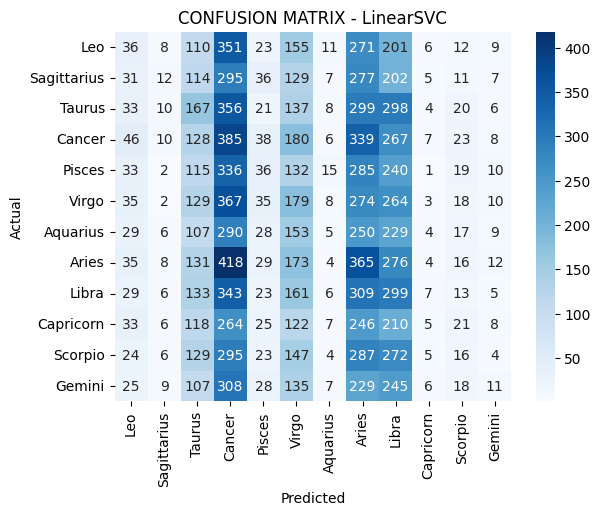

In [88]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d', xticklabels=sign_id_df.sign.values, yticklabels=sign_id_df.sign.values)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("CONFUSION MATRIX - LinearSVC", size=12);

In [40]:
# Prediction

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1,2), stop_words="english")

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [42]:
text = "       Well Kids. Tonight is the big show.  Actually, it's not really big.  There's only four bands, Planet Smashers, Catch 22, Mustard Plug and Big D and the kids table. That's not that many. I miss Warped Tour.  I'm taking the guys up..too bad I don't think I'm taking god up. That would rock rock rock. If god graces me with his presence tonight, I'll be a happy girl. I'll also be a happy girl if I meet some new boys. That's right. Another song you kids need is 'Long Goodnight,' by the get up kids, and 'I belive in a thing called love,' by the darkness. Those are pretty nifty selections. I actually wanted to catch some sleep before we hit the road, but I don't know if I'll be able too. Ugh. This will be interesting. Esecially because I have a high hate-tred, for ska. Yes, I know. That makes no sense, and why am I going right? Well, put it too you this way, it's a show, and It's in Cleveland, only $10 and I'm going with the guys. I've never been to a show with them. This will be fun! .. I think .. If I don't die in the pit first.  I'm going to go, if anyone wants to come along tonight, your more than welcome. Just bring some powerade and all will be fine.    "

print(model.predict(fitted_vectorizer.transform([text])))

['Libra']


In [43]:
text2 = "                 today's been crap, havnt felt like this for a while. im hoping its pms lol thats wot im puttin it down to, i think mayb to do with joe, but at least seems to b tlkin to me now... mayb its cos i been happy n hyper for a cple of weeks n its jus impossible to go so long without breakin down n cryin lol. i hate myself sumtimes tho, i feel so weak for lettin small things upset me, im too vulnerable wen it comes to other ppl, its pathetic but i always do it. and now im coming across as a miserable cow. im not, ive been so much better lately. its jus today. and this will pass. tho il be in germany - i dont want to be but o well. n i deserve it sumtimes, im not mean most of the time honest jus realy stupid i dnt intentionaly offend ppl very often, jus my fat ugly mouth. gona stop writin cos jus babbling randomly depressin stuff        "
print(model.predict(fitted_vectorizer.transform([text2])))

['Gemini']


In [44]:
df["sign"][105]

'Gemini'